# Step 2: Feature Engineering

According to [Wikipedia, Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive. 

This Feature engineering notebook will load the data sets created in the **Data Ingestion** notebook (`Code/1_data_ingestion.ipynb`) from an Azure storage container and combine them to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The notebook steps through several feature engineering and labeling methods to create this data set for use in our predictive maintenance machine learning solution.

**Note:** This notebook will take about 20-30 minutes to execute all cells, depending on the compute configuration you have setup. 

In [1]:
from azureml.core import Workspace, Experiment 

In [2]:
# Load workspace using configuration file 
ws = Workspace.from_config(path = '../aml_config/PredictiveMaintenanceWSConfig.json') 

Found the config file in: /data/home/ubuntu/PredictiveMaintenance/aml_config/PredictiveMaintenanceWSConfig.json


In [3]:
# Data Ingestion will be run within a separate experiment 
exp = Experiment(name = 'FeatureEngIneering', workspace = ws) 

In [4]:
# New Run is created 
run = exp.start_logging() 

In [5]:
# Now we can log any information we want 
import time
run.log('Starting Feature Engineering', time.asctime(time.localtime(time.time()))) 

In [6]:
run.tag('Description', 'Feature Engineering') 

In [7]:
# Enter your Azure blob storage details here 
ACCOUNT_NAME = "predictistorageinugjxfr"

# You can find the account key under the _Access Keys_ link in the 
# [Azure Portal](portal.azure.com) page for your Azure storage container.
ACCOUNT_KEY = "moQjKkXdNdA2xHGuPpC4YdxDeotmTkkm+Pa7zopIHcy1xNhVf5hvU+tO9OQLC3cxVG01IKvEZeSHAOEgmdrV1w==" 

In [8]:
## Setup our environment by importing required libraries
#import time
import os
import glob

# Read csv file from URL directly
import pandas as pd

# For creating some preliminary EDA plots.
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *

import datetime
from pyspark.sql.functions import to_date

import pyspark.sql.functions as F
from pyspark.sql.functions import col, unix_timestamp, round
from pyspark.sql.functions import datediff
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.sql import SparkSession

# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

# For logging model evaluation parameters back into the
# AML Workbench run history plots.
#import logging
#from azureml.logging import get_azureml_logger

#amllog = logging.getLogger("azureml")
#amllog.level = logging.INFO

# Turn on cell level logging.
#%azureml history on
#%azureml history show

# Time the notebook execution. 
# This will only make sense if you "Run all cells"
tic = time.time()

#logger = get_azureml_logger() # logger writes to AMLWorkbench runtime view

spark = SparkSession.builder.getOrCreate()

# Telemetry
#logger.log('amlrealworld.predictivemaintenance.feature_engineering','true') 
run.log('amlrealworld.predictivemaintenance.feature_engineering', True)

/anaconda/envs/py36/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


## Load raw data from Azure Blob storage container

In the **Data Ingestion** notebook (`Code/1_data_ingestion.ipynb`), we downloaded, converted and stored the following data sets into Azure blob storage:

  * **Machines**: Features differentiating each machine. For example age and model.
  * **Error**: The log of non-critical errors. These errors may still indicate an impending component failure.
  * **Maint**: Machine maintenance history detailing component replacement or regular maintenance activities withe the date of replacement.
  * **Telemetry**: The operating conditions of a machine e.g. data collected from sensors.
  * **Failure**: The failure history of a machine or component within the machine.

We first load these files. Since the Azure Blob storage account name and account key are not passed between notebooks, you'll need to provide those here again.

In [9]:
# Enter your Azure blob storage details here 
#ACCOUNT_NAME = ""

# You can find the account key under the _Access Keys_ link in the 
# [Azure Portal](portal.azure.com) page for your Azure storage container.
#ACCOUNT_KEY = ""

#-------------------------------------------------------------------------------------------
# The data from the Data Aquisition note book is stored in the dataingestion container.
CONTAINER_NAME = "dataingestion"

# The data constructed in this notebook will be stored in the featureengineering container
STORAGE_CONTAINER_NAME = "featureengineering"

# Connect to your blob service     
az_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

# We will store each of these data sets in blob storage in an 
# Azure Storage Container on your Azure subscription.
# See https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md
# for details.

# These file names detail which blob each file is stored under. 
MACH_DATA = 'machines_files.parquet'
MAINT_DATA = 'maint_files.parquet'
ERROR_DATA = 'errors_files.parquet'
TELEMETRY_DATA = 'telemetry_files.parquet'
FAILURE_DATA = 'failure_files.parquet'

# These file names detail the local paths where we store the data results.
MACH_LOCAL_DIRECT = 'dataingestion_mach_result.parquet'
ERROR_LOCAL_DIRECT = 'dataingestion_err_result.parquet'
MAINT_LOCAL_DIRECT = 'dataingestion_maint_result.parquet'
TELEMETRY_LOCAL_DIRECT = 'dataingestion_tel_result.parquet'
FAILURES_LOCAL_DIRECT = 'dataingestion_fail_result.parquet'

# This is the final data file.
FEATURES_LOCAL_DIRECT = 'featureengineering_files.parquet'

### Machines data set

Now, we load the machines data set from your Azure blob.

In [10]:
# create a local path  to store the data.
if not os.path.exists(MACH_LOCAL_DIRECT):
    os.makedirs(MACH_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MACH_DATA in blob.name:
        local_file = os.path.join(MACH_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
machines = spark.read.parquet(MACH_LOCAL_DIRECT)

print(machines.count())
machines.limit(5).toPandas().head()

3000


,machineID,model,age
0,1,model2,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model2,2


### Errors data set

Load the errors data set from your Azure blob.

In [11]:
if not os.path.exists(ERROR_LOCAL_DIRECT):
    os.makedirs(ERROR_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if ERROR_DATA in blob.name:
        local_file = os.path.join(ERROR_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
errors = spark.read.parquet(ERROR_LOCAL_DIRECT)

print(errors.count())
errors.printSchema()
errors.limit(5).toPandas().head()

35901
root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- errorID: string (nullable = true)



,datetime,machineID,errorID
0,2015-04-08 19:00:00,251,error3
1,2015-06-09 06:00:00,251,error1
2,2015-08-08 06:00:00,251,error4
3,2015-09-07 06:00:00,251,error2
4,2015-09-07 06:00:00,251,error3


### Maintenance data set

Load the maintenance data set from your Azure blob.

In [12]:
# create a local path  to store the data.
if not os.path.exists(MAINT_LOCAL_DIRECT):
    os.makedirs(MAINT_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MAINT_DATA in blob.name:
        local_file = os.path.join(MAINT_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
maint = spark.read.parquet(MAINT_LOCAL_DIRECT)

print(maint.count())
maint.limit(5).toPandas().head()

97776


,datetime,machineID,comp
0,2015-01-04 06:00:00,252,comp1
1,2015-01-19 06:00:00,252,comp4
2,2015-02-18 06:00:00,252,comp3
3,2015-03-05 06:00:00,252,comp2
4,2015-03-20 06:00:00,252,comp1


### Telemetry

Load the telemetry data set from your Azure blob.

In [13]:
# create a local path  to store the data.
if not os.path.exists(TELEMETRY_LOCAL_DIRECT):
    os.makedirs(TELEMETRY_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if TELEMETRY_DATA in blob.name:
        local_file = os.path.join(TELEMETRY_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
telemetry = spark.read.parquet(TELEMETRY_LOCAL_DIRECT)

print(telemetry.count())
telemetry.limit(5).toPandas().head()

26283000


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-08 10:00:00,501,165.775142,456.014484,96.779707,40.200315
1,2015-01-08 11:00:00,501,167.694494,415.396525,106.346838,39.454320
2,2015-01-08 12:00:00,501,149.286911,549.794168,110.590462,46.649346
3,2015-01-08 13:00:00,501,164.315444,485.343432,102.644426,38.615502
4,2015-01-08 14:00:00,501,178.789891,447.830204,100.238279,36.380291


### Failures data set

Load the failures data set from your Azure blob.

In [14]:
# create a local path  to store the data.
if not os.path.exists(FAILURES_LOCAL_DIRECT):
    os.makedirs(FAILURES_LOCAL_DIRECT)
    print('DONE creating a local directory!')


# download the entire parquet result folder to local path for a new run 
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if FAILURE_DATA in blob.name:
        local_file = os.path.join(FAILURES_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

failures = spark.read.parquet(FAILURES_LOCAL_DIRECT).dropDuplicates(['machineID', 'datetime'])

print(failures.count())
failures.limit(5).toPandas().head()

6368


,datetime,machineID,failure
0,2015-07-31 06:00:00,7,comp1
1,2015-02-17 06:00:00,179,comp4
2,2015-12-28 06:00:00,191,comp1
3,2015-06-13 06:00:00,221,comp2
4,2015-06-28 06:00:00,262,comp2


## Feature engineering 

Our feature engineering will combine the different data sources together to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The ultimate goal is to generate a single record for each time unit within each asset. The record combines features and labels to be fed into the machine learning algorithm.

Predictive maintenance take historical data, marked with a timestamp, to predict current health of a component and the probability of failure within some future window of time. These problems can be characterised as a _classification method_ involving _time series_ data. Time series, since we want to use historical observations to predict what will happen in the future. Classification, because we classify the future as having a probability of failure.

### Lag features

There are many ways of creating features from the time series data. We start by dividing the duration of data collection into time units where each record belongs to a single point in time for each asset. The measurement unit for is in fact arbitrary. Time can be in seconds, minutes, hours, days, or months, or it can be measured in cycles, miles or transactions. The measurement choice is typically specific to the use case domain.

Additionally, the time unit does not have to be the same as the frequency of data collection. For example, if temperature values were being collected every 10 seconds, picking a time unit of 10 seconds for analysis may inflate the number of examples without providing any additional information if the temperature changes slowly. A better strategy may be to average the temperature over a longer time horizon which might better capture variations that contribute to the target outcome.

Once we set the frequency of observations, we want to look for trends within measures, over time, in order to predict performance degradation, which we would like to connect to how likely a component will fail. We create features for these trends within each record using time lags over previous observations to check for these performance changes. The lag window size $W$ is a hyper parameter that we can optimize. The following figures indicate a _rolling aggregate window_ strategy for averaging a measure $t_i$ over a window $W = 3$ previous observations.

![Rolling windows](../images/rolling-aggregate-features.png)

We are note constrained to averages, we can roll aggregates over counts, average, the standard deviation, outliers based on standard deviations, CUSUM measures, minimum and maximum values for the window. 

We could also use a tumbling window approach, if we were interested in a different time window measure than the frequncy of the observations. For example, we might have obersvations evert 6 or 12 hours, but want to create features aligned on a day or week basis.  
![Tumbling windows](../images/tumbling-aggregate-features.png)

In the following sections, we will build our features using only a rolling strategy to demonstrate the process. We align our data, and then build features along those normalized observations times. We start with the telemetry data.

## Telemetry features

Because the telemetry data set is the largest time series data we have, we start feature engineering here. The telemetry data has 8761000 hourly observations for out 1000 machines. We can improve the model performance by aligning our data by aggregating average sensor measures on a tumbling 12 hour window. In this case we replace the raw data with the tumbling window data, reducing the sensor data to 731000 observations. This will directly reduce the computaton time required to do the feature engineering, labeling and modeling required for our solution.    

Once we have the reduced data, we set up our lag features by compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over time. 

The following code blocks alignes the data on 12 hour observations and calculates a rolling mean and standard deviation of the telemetry data over the last 12, 24 and 36 hour lags.

In [15]:
# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Which features are we interested in telemetry data set
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [16]:
# We choose windows for our rolling windows 12hrs, 24 hrs and 36 hrs
lags = [12, 24, 36]

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))

print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 1)).limit(10).toPandas().head(10)

731000


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,pressure_rollingstd_12,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36
0,1,2015-04-02 12:00:00,169.504358,458.080859,98.853100,40.206282,172.276693,453.914465,100.149237,39.388604,...,1.967764,1.450408,2.574380,7.842277,0.697507,0.642817,2.029878,4.257344,0.469016,0.696241
1,1,2015-05-12 00:00:00,174.752893,447.869796,99.104835,37.912595,173.328100,451.021134,99.197901,39.176060,...,3.686390,1.586467,3.872359,4.502588,2.144001,0.972561,2.842595,2.876937,1.613863,0.869366
2,1,2015-07-26 12:00:00,164.973477,440.217397,94.586757,41.848857,167.125874,448.332605,95.745427,41.503863,...,3.237066,0.969911,1.599882,5.677769,1.470616,0.448602,1.340792,2.718405,0.902162,0.404061
3,1,2015-08-04 00:00:00,167.911567,492.569736,100.299672,39.586859,168.887626,485.283536,99.435951,39.745648,...,3.018383,1.784219,1.965474,5.006491,1.181980,0.767992,1.343253,2.728301,0.960705,0.679509
4,1,2015-08-23 12:00:00,170.813463,433.742572,101.722879,40.204782,170.125657,425.172196,101.880923,39.585259,...,1.992043,1.527793,2.245183,3.576078,1.881253,0.712531,1.665154,2.154706,1.607367,0.347801
5,1,2015-12-17 00:00:00,166.746403,461.177019,99.965307,39.030648,168.473344,457.179697,99.010242,39.161199,...,2.795527,1.483904,2.241567,5.203382,1.844869,1.125516,0.974139,5.938996,0.894611,0.760292
6,1,2015-02-16 12:00:00,162.764982,467.345254,93.235051,40.631218,165.212582,462.714226,94.687890,41.285949,...,2.040776,1.726990,2.210824,11.000059,0.922132,0.853953,2.718721,6.540091,0.939278,0.673975
7,1,2015-10-30 12:00:00,172.185544,456.572562,99.934121,50.627328,172.254541,458.164872,100.384868,48.665114,...,2.907054,2.345860,0.792869,16.982184,1.709924,1.898605,0.914669,12.779607,1.622618,1.136515
8,1,2015-10-31 12:00:00,170.453718,382.620105,97.386500,51.473313,172.445912,397.881664,96.610581,51.898352,...,3.420846,1.257551,1.762591,13.068849,1.415854,0.326730,2.653562,13.276990,1.098551,0.344981
9,1,2015-12-11 12:00:00,172.870633,454.444227,100.745268,39.492203,173.957241,453.429312,101.286805,39.202149,...,2.544891,1.393332,3.237451,8.295104,1.528917,0.728565,2.093676,6.602655,1.369296,0.431994


## Errors features

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type within a lag window. 

Again, we align the error counts data by tumbling over the 12 hour window using a join with telemetry data. 

In [17]:
# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+'_rollingmean_24', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

731000


,machineID,dt_truncated,error1sum_rollingmean_24,error2sum_rollingmean_24,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24
0,26,2015-04-27 12:00:00,0.0,0.0,0.0,0.0,0.0
1,26,2015-06-28 12:00:00,0.0,0.0,0.0,0.0,0.0
2,26,2015-08-11 00:00:00,0.0,0.0,0.0,0.0,0.0
3,29,2015-03-04 00:00:00,0.0,0.0,0.0,0.0,0.0
4,29,2015-04-06 00:00:00,0.0,0.0,0.0,0.0,0.0
5,29,2015-05-14 12:00:00,0.0,0.0,0.0,0.0,0.0
6,29,2015-06-20 12:00:00,0.0,0.0,0.0,0.0,0.0
7,29,2015-10-16 00:00:00,0.0,0.0,0.0,0.0,0.0
8,474,2015-05-29 12:00:00,0.0,0.0,0.0,0.0,0.0
9,474,2015-09-15 00:00:00,0.0,0.0,0.0,0.0,0.0


## Days since last replacement from maintenance 

A crucial data set in this example is the use of maintenance records, which contain the information regarding component replacement. Possible features from this data set can be the number of replacements of each component over time or to calculate how long it has been since a component has been replaced. Replacement time is expected to correlate better with component failures since the longer a component is used, the more degradation would be expected.

As a side note, creating lagging features from maintenance data is not straight forward. This type of ad-hoc feature engineering is very common in predictive maintenance as domain knowledge plays a crucial role in understanding the predictors of a failure problem. In the following code blocks, the days since last component replacement are calculated for each component from the maintenance data. We start by counting the component replacements for the set of machines.

In [18]:
# create a column for each component replacement
maint_replace = (maint.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

25121


,machineID,datetime_maint,comp1sum,comp2sum,comp3sum,comp4sum
0,191,2015-12-28 06:00:00,3,0,0,0
1,567,2015-09-17 06:00:00,0,0,0,3
2,301,2015-04-04 06:00:00,3,3,0,0
3,852,2015-06-14 06:00:00,0,0,3,0
4,942,2015-09-23 06:00:00,0,0,3,3
5,66,2015-09-30 06:00:00,0,0,3,0
6,370,2015-07-22 06:00:00,0,3,0,3
7,512,2015-05-03 06:00:00,0,0,3,0
8,427,2015-06-15 06:00:00,0,0,3,3
9,490,2015-10-26 06:00:00,3,3,0,0


Replacement features are then created by tracking the number of days between each component replacement. We'll repeat these calculations for each of the four components and join them together into a maintenance feature table.

First component number 1 (`comp1`):

In [19]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = (telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)
                   .withColumnRenamed('dt_truncated','datetime_tel'))

# Grab component 1 records
maint_comp1 = (maint_replace.where(col("comp1sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp2sum', 'comp3sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp1 = (telemetry_times.join(maint_comp1, 
                                        ((telemetry_times ['machineID']== maint_comp1['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp1['datetime_maint']) 
                                         & ( maint_comp1['comp1sum'] == '1')))
                   .drop(maint_comp1.machineID))

# Calculate the number of days between replacements
comp1 = (maint_tel_comp1.withColumn("sincelastcomp1", 
                                    datediff(maint_tel_comp1.datetime_tel, maint_tel_comp1.datetime_maint))
         .drop(maint_tel_comp1.datetime_maint).drop(maint_tel_comp1.comp1sum))

print(comp1.count())
comp1.filter(comp1.machineID == '625').orderBy(comp1.datetime_tel).limit(20).toPandas().head(20)

0


,machineID,datetime_tel,sincelastcomp1


Then component 2 (`comp2`):

In [20]:
# Grab component 2 records
maint_comp2 = (maint_replace.where(col("comp2sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp3sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp2 = (telemetry_times.join(maint_comp2, 
                                        ((telemetry_times ['machineID']== maint_comp2['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp2['datetime_maint']) 
                                         & ( maint_comp2['comp2sum'] == '1')))
                   .drop(maint_comp2.machineID))

# Calculate the number of days between replacements
comp2 = (maint_tel_comp2.withColumn("sincelastcomp2", 
                                    datediff(maint_tel_comp2.datetime_tel, maint_tel_comp2.datetime_maint))
         .drop(maint_tel_comp2.datetime_maint).drop(maint_tel_comp2.comp2sum))

print(comp2.count())
comp2.filter(comp2.machineID == '625').orderBy(comp2.datetime_tel).limit(5).toPandas().head(5)

0


,machineID,datetime_tel,sincelastcomp2


Then component 3 (`comp3`):

In [21]:
# Grab component 3 records
maint_comp3 = (maint_replace.where(col("comp3sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp3 = (telemetry_times.join(maint_comp3, ((telemetry_times ['machineID']==maint_comp3['machineID']) 
                                                      & (telemetry_times ['datetime_tel'] > maint_comp3['datetime_maint']) 
                                                      & ( maint_comp3['comp3sum'] == '1')))
                   .drop(maint_comp3.machineID))

# Calculate the number of days between replacements
comp3 = (maint_tel_comp3.withColumn("sincelastcomp3", 
                                    datediff(maint_tel_comp3.datetime_tel, maint_tel_comp3.datetime_maint))
         .drop(maint_tel_comp3.datetime_maint).drop(maint_tel_comp3.comp3sum))


print(comp3.count())
comp3.filter(comp3.machineID == '625').orderBy(comp3.datetime_tel).limit(5).toPandas().head(5)

0


,machineID,datetime_tel,sincelastcomp3


and component 4 (`comp4`):

In [22]:
# Grab component 4 records
maint_comp4 = (maint_replace.where(col("comp4sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp3sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp4 = telemetry_times.join(maint_comp4, ((telemetry_times['machineID']==maint_comp4['machineID']) 
                                                     & (telemetry_times['datetime_tel'] > maint_comp4['datetime_maint']) 
                                                     & (maint_comp4['comp4sum'] == '1'))).drop(maint_comp4.machineID)

# Calculate the number of days between replacements
comp4 = (maint_tel_comp4.withColumn("sincelastcomp4", 
                                    datediff(maint_tel_comp4.datetime_tel, maint_tel_comp4.datetime_maint))
         .drop(maint_tel_comp4.datetime_maint).drop(maint_tel_comp4.comp4sum))

print(comp4.count())
comp4.filter(comp4.machineID == '625').orderBy(comp4.datetime_tel).limit(5).toPandas().head(5)

0


,machineID,datetime_tel,sincelastcomp4


Now, we join the four component replacement tables together. Once joined, align the data by tumbling the average across 12 hour observation windows.

In [23]:
# Join component 3 and 4
comp3_4 = (comp3.join(comp4, ((comp3['machineID'] == comp4['machineID']) 
                              & (comp3['datetime_tel'] == comp4['datetime_tel'])), "left")
           .drop(comp4.machineID).drop(comp4.datetime_tel))

# Join component 2 to 3 and 4
comp2_3_4 = (comp2.join(comp3_4, ((comp2['machineID'] == comp3_4['machineID']) 
                                  & (comp2['datetime_tel'] == comp3_4['datetime_tel'])), "left")
             .drop(comp3_4.machineID).drop(comp3_4.datetime_tel))

# Join component 1 to 2, 3 and 4
comps_feat = (comp1.join(comp2_3_4, ((comp1['machineID'] == comp2_3_4['machineID']) 
                                      & (comp1['datetime_tel'] == comp2_3_4['datetime_tel'])), "left")
               .drop(comp2_3_4.machineID).drop(comp2_3_4.datetime_tel)
               .groupBy("machineID", "datetime_tel")
               .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                    F.max('sincelastcomp2').alias('sincelastcomp2'), 
                    F.max('sincelastcomp3').alias('sincelastcomp3'), 
                    F.max('sincelastcomp4').alias('sincelastcomp4'))
               .fillna(0))

# Choose the time_val hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

0


,machineID,dt_truncated,comp1sum,comp2sum,comp3sum,comp4sum


## Machine features

The machine features capture specifics of the individuals. These can be used without further modification since it include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

We do need to create a set of dummy features, a set of boolean variables, to indicate the model of the machine. This can either be done manually, or using a _one-hot encoding_ step. We use the one-hot encoding for demonstration purposes. 

In [24]:
# one hot encoding of the variable model, basically creates a set of dummy boolean variables
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

3000


,machineID,model,age,model_encoded
0,1,model2,18,"(0.0, 0.0, 1.0)"
1,2,model4,7,"(0.0, 1.0, 0.0)"
2,3,model3,8,"(1.0, 0.0, 0.0)"
3,4,model3,7,"(1.0, 0.0, 0.0)"
4,5,model2,2,"(0.0, 0.0, 1.0)"
5,6,model3,7,"(1.0, 0.0, 0.0)"
6,7,model4,20,"(0.0, 1.0, 0.0)"
7,8,model3,16,"(1.0, 0.0, 0.0)"
8,9,model1,7,"(0.0, 0.0, 0.0)"
9,10,model1,10,"(0.0, 0.0, 0.0)"


## Merging feature data

Next, we merge the telemetry, maintenance, machine and error feature data sets into a large feature data set. Since most of the data has already been aligned on the 12 hour observation period, we can merge with a simple join strategy.

In [25]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))

print(final_feat.count())
final_feat.filter(final_feat.machineID == '625').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

2193000


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded
0,625,2015-01-01 12:00:00,167.726562,457.023539,97.671510,43.288417,168.903523,454.765815,97.818506,44.520524,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
1,625,2015-01-01 12:00:00,167.726562,457.023539,97.671510,43.288417,168.903523,454.765815,97.818506,44.520524,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
2,625,2015-01-01 12:00:00,167.726562,457.023539,97.671510,43.288417,168.903523,454.765815,97.818506,44.520524,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
3,625,2015-01-02 00:00:00,167.669833,446.268601,94.255945,43.192112,166.942467,453.117332,95.029026,42.636115,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
4,625,2015-01-02 00:00:00,167.669833,446.268601,94.255945,43.192112,166.942467,453.117332,95.029026,42.636115,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
5,625,2015-01-02 00:00:00,167.669833,446.268601,94.255945,43.192112,166.942467,453.117332,95.029026,42.636115,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
6,625,2015-01-02 12:00:00,172.036832,466.794278,99.847922,40.537832,169.998556,458.611466,98.524816,40.788719,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
7,625,2015-01-02 12:00:00,172.036832,466.794278,99.847922,40.537832,169.998556,458.611466,98.524816,40.788719,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
8,625,2015-01-02 12:00:00,172.036832,466.794278,99.847922,40.537832,169.998556,458.611466,98.524816,40.788719,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"
9,625,2015-01-03 00:00:00,170.684677,455.829133,102.043135,40.259893,171.506318,459.226593,102.043397,40.308199,...,0.0,0.0,0.0,None,None,None,None,model3,13,"(1.0, 0.0, 0.0)"


# Label construction

Predictive maintenance is supervised learning. To train a model to predict failures requires examples of failures, and the time series of observations leading up to those failures. Additionally, the model needs examples of periods of healthy operation in order to discern the difference between the two states. The classification between these states is typically a boolean label (healthy vs failed).

Once we have the healthy vs. failure states, the predictive maintenance approach is only useful if the method will give some advanced warning of an impending failure. To accomplish this _prior warning_ criteria, we slightly modify the label definition from a _failure event_ which occurs at a specific moment in time, to a longer window of _failure event occurs within this window_. The window length is defined by the business criteria. Is knowing a failure will occur within 12 hours, enough time to prevent the failure from happening? Is 24 hours, or 2 weeks? The ability of the model to accurately predict an impending failure is dependent sizing this window. If the failure signal is short, longer windows will not help, and can actually degrade, the potential performance.   

To acheive the redefinition of failure to _about to fail_, we over label failure events, labeling all observations within the failure warning window as failed. The prediction problem then becomes estimating the probability of failure within this window. 

![over label](../images/labelling-for-binary-classification.png)

For this example scenerio, we estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 7 days due to a component failure (component 1, 2, 3, or 4). 

Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure="comp1", and so on for components 2, 3, and 4; all records not within 7 days of a component failure have failure="none".

The first step is to alighn the failure data to the feature observation time points (every 12 hours).

In [26]:
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

fail_diff = (failures.withColumn("dt_truncated", dt_truncated)
             .drop(failures.datetime))

print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)


6368


,machineID,failure,dt_truncated
0,7,comp1,2015-07-31 12:00:00
1,179,comp4,2015-02-17 12:00:00
2,191,comp1,2015-12-28 12:00:00
3,221,comp2,2015-06-13 12:00:00
4,262,comp2,2015-06-28 12:00:00
5,288,comp2,2015-10-19 12:00:00
6,322,comp3,2015-11-27 12:00:00
7,346,comp4,2015-02-17 12:00:00
8,352,comp1,2015-11-27 12:00:00
9,382,comp3,2015-11-22 12:00:00


Next, we convert the labels from text to numeric values. In the end, this will transform the problem from boolean of 'healthy'/'impending failure' to a multiclass 'healthy'/'component `n` impending failure'.

In [ ]:
# map the failure data to final feature matrix
labeled_features = (final_feat.join(fail_diff, 
                                    ((final_feat['machineID'] == fail_diff['machineID']) 
                                     & (final_feat['dt_truncated'] == fail_diff['dt_truncated'])), "left")
                    .drop(fail_diff.machineID).drop(fail_diff.dt_truncated)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                                                labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

2193000


To verify we have assigned the component failure records correctly, we count the failure classes within the feature data.

In [28]:
# To get the frequency of each component failure 
df = labeled_features.select(labeled_features.failure).toPandas()
df['failure'].value_counts()

0.0    2173896
2.0       7401
1.0       5658
4.0       3309
3.0       2736
Name: failure, dtype: int64

To now, we have labels as _failure events_. To convert to _impending failure_, we over label over the previous 7 days as _failed_.


In [29]:
# lag values to manually backfill label (bfill =7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# Create the previous 7 days 
labeled_features = (labeled_features.withColumn("prev_value1", 
                                                F.lag(labeled_features.failure).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value2", 
                                                F.lag(labeled_features.prev_value1).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value3", 
                                                F.lag(labeled_features.prev_value2).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value4", 
                                                F.lag(labeled_features.prev_value3).
                                                over(my_window)).fillna(0)) 
labeled_features = (labeled_features.withColumn("prev_value5", 
                                                F.lag(labeled_features.prev_value4).
                                                over(my_window)).fillna(0)) 
labeled_features = (labeled_features.withColumn("prev_value6", 
                                                F.lag(labeled_features.prev_value5).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value7", 
                                                F.lag(labeled_features.prev_value6).
                                                over(my_window)).fillna(0))

# Create a label features
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + 
                                                labeled_features.prev_value1 +
                                                labeled_features.prev_value2 +
                                                labeled_features.prev_value3 +
                                                labeled_features.prev_value4 +
                                                labeled_features.prev_value5 + 
                                                labeled_features.prev_value6 + 
                                                labeled_features.prev_value7))

# Restrict the label to be on the range of 0:4, and remove extra columns
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0)
                                                .otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

2193000


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,26,2016-01-01 12:00:00,156.344085,468.057739,124.013028,42.178511,162.025185,475.175738,128.051943,42.778459,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
1,26,2016-01-01 12:00:00,156.344085,468.057739,124.013028,42.178511,162.025185,475.175738,128.051943,42.778459,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
2,26,2016-01-01 12:00:00,156.344085,468.057739,124.013028,42.178511,162.025185,475.175738,128.051943,42.778459,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
3,26,2016-01-01 00:00:00,163.950541,463.526286,126.531407,42.349105,164.387412,458.076924,125.984343,41.609348,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
4,26,2016-01-01 00:00:00,163.950541,463.526286,126.531407,42.349105,164.387412,458.076924,125.984343,41.609348,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
5,26,2016-01-01 00:00:00,163.950541,463.526286,126.531407,42.349105,164.387412,458.076924,125.984343,41.609348,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
6,26,2015-12-31 12:00:00,170.101450,444.259746,124.232805,40.276008,169.520645,447.900337,121.007364,40.509231,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
7,26,2015-12-31 12:00:00,170.101450,444.259746,124.232805,40.276008,169.520645,447.900337,121.007364,40.509231,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
8,26,2015-12-31 12:00:00,170.101450,444.259746,124.232805,40.276008,169.520645,447.900337,121.007364,40.509231,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
9,26,2015-12-31 00:00:00,165.952772,453.459165,98.901505,40.877614,165.591482,445.886418,97.494281,41.431352,...,0.0,0.0,0.0,0.0,0.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0


To verify the label construction, we plot a sample of four machines over the data set life time. We expect the labels to cluster for each component, since there are 7 day windows of "fail". We have omitted the healthy labels, as they are uninformative. Since the labels are actually classes, the plot as four distinct values on the y-axis.

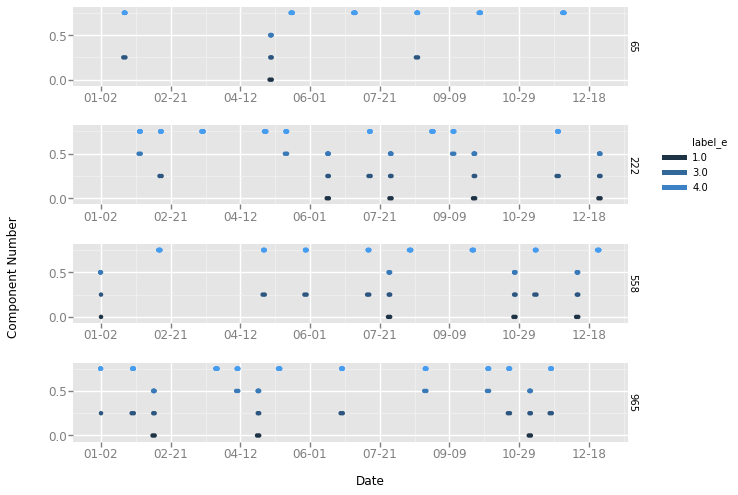

<ggplot: (-9223363243238408942)>

In [30]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID')

Here we see that most of the days are marked as healthy (label = 0 are omitted for plot performance, though the dates are still accurate). Each of the four machines have multiple failures over the course of the dataset. Each labeled failure includes the date of failure and the previous seven days, all are marked with the number indicating the component that failed. 

The goal of the model will be to predict when a failure will occur and which component will fail simultaneously. This will be a multiclass classification problem, though we could pivot the data to individually predict binary failure of a component instead of a machine.

## Write the feature data to cloud storage

Write the final labeled feature data as parquet file an Azure blob storage container. For technical details, see:
https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md


In [31]:
# Create a new container if necessary, otherwise you can use an existing container.
# This command creates the container if it does not already exist. Else it does nothing.
az_blob_service.create_container(STORAGE_CONTAINER_NAME, 
                                 fail_on_exist=False, 
                                 public_access=PublicAccess.Container)

# Write labeled feature data to blob for use in the next notebook
labeled_features.write.mode('overwrite').parquet(FEATURES_LOCAL_DIRECT)

# Delete the old data.
for blob in az_blob_service.list_blobs(STORAGE_CONTAINER_NAME):
    if FEATURES_LOCAL_DIRECT in blob.name:
        az_blob_service.delete_blob(STORAGE_CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(FEATURES_LOCAL_DIRECT + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(STORAGE_CONTAINER_NAME, name, name)

print("Feature engineering final dataset files saved!")

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))

#logger.log("Feature Engineering Run time", ((toc - tic)/60))
run.log('Feature Engineering Run time', ((toc - tic)/60)) 

KeyboardInterrupt: 

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:38763)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused--- Logging error ---
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

In [ ]:
# Mark the run as completed 
run.complete() 

# Conclusion

The next step is to build and compare machine learning models using the feature data set we have just created. The `Code\3_model_building.ipynb` notebook works through building a Decision Tree Classifier and a Random Forest Classifier using this data set. 
